In [219]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import seaborn as sns

sns.set_theme()

In [220]:
df = pd.read_csv('covid.csv', index_col=0)
df

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",Total Cases/1M pop,Deaths/1M pop,Total Tests,Tests/1M pop,Population,Region
0,India,43072486,NaN,523753.0,NaN,42530622.0,NaN,18111.0,698.0,30664,373.0,836945383.0,595826.0,1404680388,Asia
1,S. Korea,17194616,50551.0,22724.0,136.0,NaN,NaN,NaN,526.0,334855,443.0,15804065.0,307775.0,51349433,Asia
2,Turkey,15028397,NaN,98751.0,NaN,14927975.0,NaN,1671.0,975.0,174770,1148.0,158778055.0,1846480.0,85989599,Asia
3,Vietnam,10644700,6068.0,43038.0,1.0,9245528.0,3225.0,1356134.0,594.0,107597,435.0,85796776.0,867234.0,98931474,Asia
4,Japan,7813849,42313.0,29506.0,39.0,7356289.0,36932.0,428054.0,173.0,62127,235.0,48589480.0,386329.0,125772339,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Liberia,7434,NaN,294.0,NaN,5747.0,NaN,1393.0,2.0,1410,56.0,139824.0,26513.0,5273788,Africa
222,Chad,7411,NaN,193.0,NaN,4874.0,NaN,2344.0,NaN,429,11.0,191341.0,11071.0,17282572,Africa
223,Sao Tome and Principe,5957,NaN,73.0,NaN,5880.0,NaN,4.0,NaN,26293,322.0,29036.0,128161.0,226559,Africa
224,Western Sahara,10,NaN,1.0,NaN,9.0,NaN,0.0,NaN,16,2.0,NaN,NaN,624037,Africa


In [221]:
excludes = ['New Cases', 'New Deaths', 'New Recovered']

new_df = df.loc[:, ~df.columns.isin(excludes)]
new_df = new_df[new_df.isnull().sum(axis=1)/len(new_df.columns) < 0.3]

<AxesSubplot:>

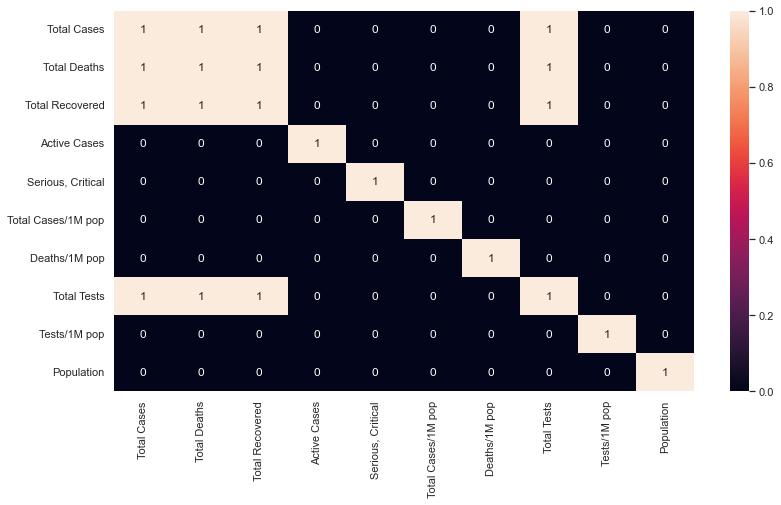

In [222]:
corr = new_df.corr()

def set_value_for_corr(x):
    if x > 0.7:
        return 1
    elif x < -0.7:
        return -1
    else:
        return 0
    

corr = corr.applymap(set_value_for_corr)
plt.figure(figsize=(13, 7))
sns.heatmap(corr, annot=True)


## Add Rate columns ##

In [223]:
new_df['Death rate'] = new_df['Total Deaths'] / new_df['Total Cases']
new_df['Recovery rate'] = new_df['Total Recovered'] / new_df['Total Cases']
new_df['Active rate'] = new_df['Active Cases'] / new_df['Total Cases']
new_df['Serious rate'] = new_df['Serious, Critical'] / new_df['Active Cases']
new_df['Cases per test'] = new_df['Total Cases'] / new_df['Total Tests']

## Add Country codes ##

In [224]:
to_country_code = json.loads(open('country-codes.json','r').read())['Country Code']
new_df['Country Code'] = new_df['Country'].apply(lambda x: to_country_code[x])

## Add Continents ##

In [225]:
cnt = requests.get('https://datahub.io/core/country-codes/r/0.json').content
data = json.loads(cnt.decode('utf-8'))
country_mapping = {}
for c in data:
    country_mapping[c['ISO3166-1-Alpha-3']] = c['Continent']
new_df['Continent'] = new_df['Country Code'].apply(lambda x: country_mapping[x] if isinstance(x, str) else np.nan)

## Scatterplot ##

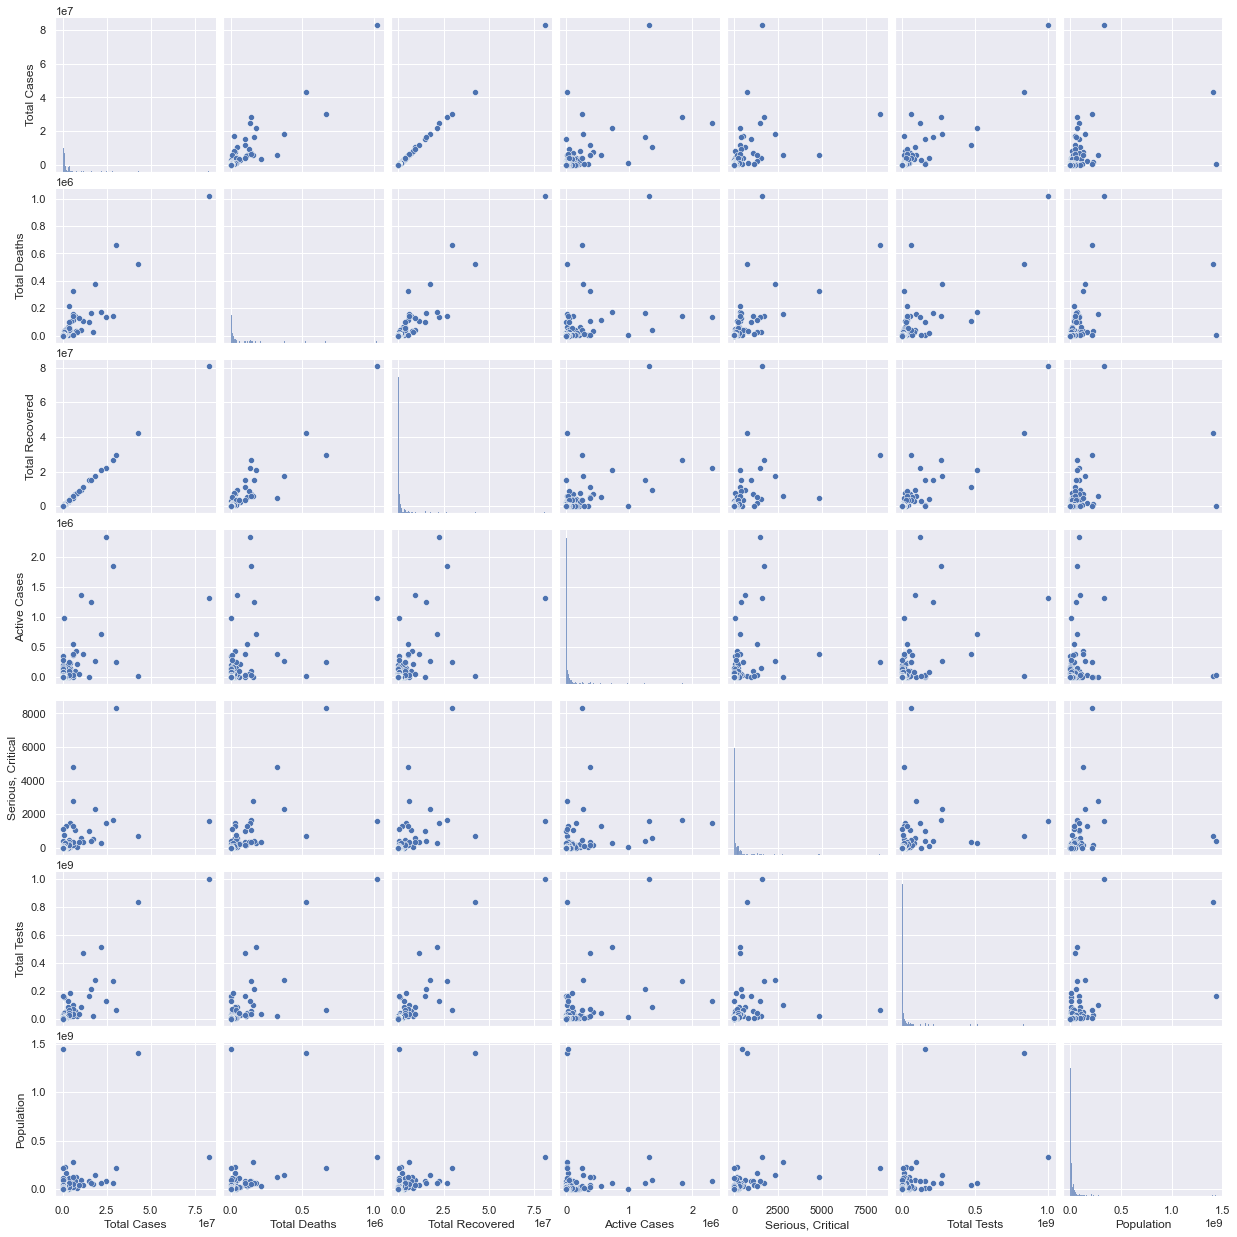

In [226]:
sns.pairplot(data=new_df[['Total Cases', 'Total Deaths', 
                          'Total Recovered', 'Active Cases', 
                          'Serious, Critical', 'Total Tests', 'Population']]);

## Scatterplot + Regression ##

In [227]:
def scatter_with_regression_plot(x_col, y_col):
    fig, ax = plt.subplots()
    sns.scatterplot(x=x_col, y=y_col)
    sns.regplot(x=x_col, y=y_col, ci=None, scatter=False, color='orange', line_kws={'linewidth':3});

### Mối quan hệ giữa các cột `Total Tests`, `Population`, `Total Deaths` và `Total Cases` ###

- Ý nghĩa của cột `Tests/1M pop` chính là tỉ lệ test trên 1 triệu dân, cũng là thương của cột `Total Tests` và cột `Population`.
- Cột `Death Rate` được tính bằng thương của cột `Total Deaths` và `Total Cases`.

Như vậy qua việc trực quan giữa cột `Test/1M pop` và `Death Rate`, ta sẽ xem được mối quan hệ giữa 4 cột `Total Tests`, `Population`, `Total Deaths` và `Total Cases`.

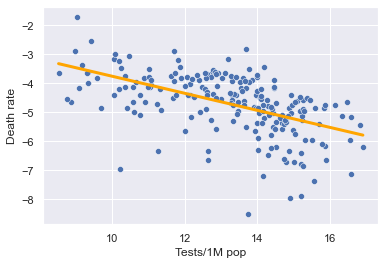

In [237]:
scatter_with_regression_plot(np.log(new_df['Tests/1M pop']), np.log(new_df['Death rate']))

Có vẻ như khi tích cực thực hiện test covid, chúng ta sẽ nhanh chóng phòng ngừa được dịch bệnh và giảm tỉ lệ tử vong của những người mắc bệnh.

### Mối quan hệ giữa tỉ lệ mắc bệnh và tỉ lệ tử vong của 1 quốc gia ###

Ta sẽ xem xét liệu có mối quan hệ giữa 2 cột `Total Cases/1M pop` và `Deaths/1M pop`. 

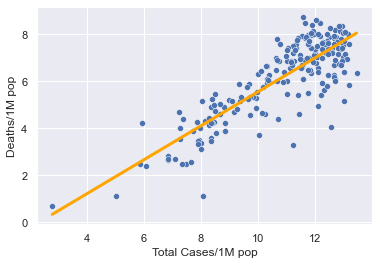

In [242]:
scatter_with_regression_plot(np.log(new_df['Total Cases/1M pop']), np.log(new_df['Deaths/1M pop']))

Có vẻ như một quốc gia có tỉ lệ mắc trên tổng dân số càng cao thì tử lệ tử vong trên tổng dân số cũng cao.

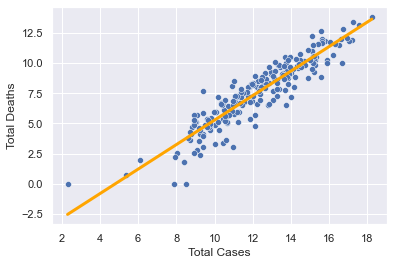

In [81]:
scatter_with_regression_plot(new_df, 'Total Cases', 'Total Deaths')

### Total Recovered vs Total Cases ###

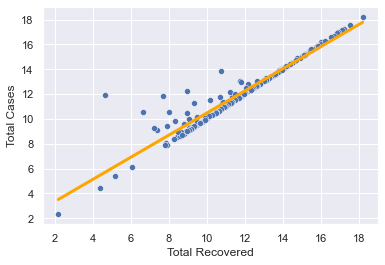

In [53]:
scatter_with_regression_plot(new_df, 'Total Recovered', 'Total Cases')

### Total Cases vs Total Tests ###

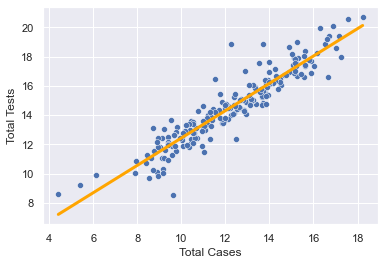

In [46]:
fig, ax = plt.subplots()
x = np.log(new_df['Total Cases'])
y = np.log(new_df['Total Tests'])
sns.scatterplot(x=x, y=y)
sns.regplot(x=x, y=y, ci=None, scatter=False, color='orange', line_kws={'linewidth':3});

<AxesSubplot:>

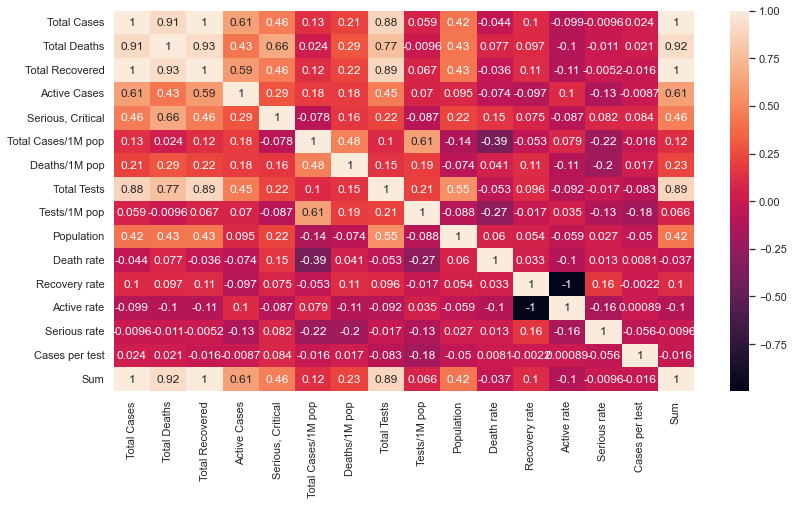

In [230]:
copy_df = new_df.copy()
copy_df['Sum'] = copy_df['Active Cases'] + copy_df['Total Recovered'] + copy_df['Total Deaths']

#copy_df = pd.DataFrame(np.array([[1,4],[3,2], [2, 3],[4,8]]), columns=['x','y'])
#copy_df['z'] = copy_df['x'] + copy_df['y']
corr = copy_df.corr()


def set_value_for_corr(x):
    if x > 0.7:
        return 1
    elif x < -0.7:
        return -1
    else:
        return 0
    

#corr = corr.applymap(set_value_for_corr)
plt.figure(figsize=(13, 7))
sns.heatmap(corr, annot=True)

In [216]:
asia = pd.read_excel('Asia.xlsx', index_col=0)
asia['Region'] = 'Asia'
for i in ['Europe', 'Oceania', 'NA', 'SA', 'Africa']:
    temp = pd.read_excel(f'{i}.xlsx')
    if i == 'NA':
        temp['Region'] = 'North America'
    elif i == 'SA':
        temp['Region'] = 'South America'
    else:
        temp['Region'] = i
        
    asia = pd.concat([asia, temp], ignore_index=True)
    
asia.columns.values[9] = 'Total Cases/1M pop'
asia

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",Total Cases/1M pop,Deaths/1M pop,Total Tests,Tests/1M pop,Population,Region,#
0,India,43072486,NaN,523753.0,NaN,42530622.0,NaN,18111.0,698.0,30664,373.0,836945383.0,595826.0,1404680388,Asia,NaN
1,S. Korea,17194616,50551.0,22724.0,136.0,NaN,NaN,NaN,526.0,334855,443.0,15804065.0,307775.0,51349433,Asia,NaN
2,Turkey,15028397,NaN,98751.0,NaN,14927975.0,NaN,1671.0,975.0,174770,1148.0,158778055.0,1846480.0,85989599,Asia,NaN
3,Vietnam,10644700,6068.0,43038.0,1.0,9245528.0,3225.0,1356134.0,594.0,107597,435.0,85796776.0,867234.0,98931474,Asia,NaN
4,Japan,7813849,42313.0,29506.0,39.0,7356289.0,36932.0,428054.0,173.0,62127,235.0,48589480.0,386329.0,125772339,Asia,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Liberia,7434,NaN,294.0,NaN,5747.0,NaN,1393.0,2.0,1410,56.0,139824.0,26513.0,5273788,Africa,54.0
222,Chad,7411,NaN,193.0,NaN,4874.0,NaN,2344.0,NaN,429,11.0,191341.0,11071.0,17282572,Africa,55.0
223,Sao Tome and Principe,5957,NaN,73.0,NaN,5880.0,NaN,4.0,NaN,26293,322.0,29036.0,128161.0,226559,Africa,56.0
224,Western Sahara,10,NaN,1.0,NaN,9.0,NaN,0.0,NaN,16,2.0,NaN,NaN,624037,Africa,57.0


In [218]:
asia.to_csv('covid.csv')